# RAT SNAKE

(300, 600)
(300, 600)
float64


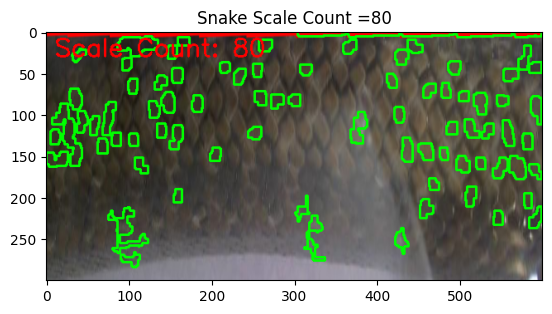

In [6]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def Canny_edge_detector(gimg,thlow = None,thhigh = None):
    gimg = cv2.GaussianBlur(gimg,(5,5),1.4)

    #2 - Compute Gradient
    gradient_x = cv2.Sobel(np.float32(gimg),cv2.CV_64F, 1, 0, 3)
    gradient_y = cv2.Sobel(np.float32(gimg),cv2.CV_64F, 0, 1, 3)

    #3- Compute Magnitude and Direction
    mag,dir = cv2.cartToPolar(gradient_x,gradient_y,angleInDegrees=True)

    # Setting minimum and maximum thresholds for Hysterisis Thresholding
    mag_max = np.max(mag)
    if not thlow: thlow = mag_max * 0.1
    if not thhigh: thhigh = mag_max  * 0.5

    height, width = gimg.shape

    #For every pixel:
    for i_x in range(width):
        for i_y in range(height):
            grad_ang = dir[i_y, i_x]
            grad_ang = abs(grad_ang - 180) if abs(grad_ang) > 180 else abs(grad_ang)

            # X-axis
            if grad_ang <= 22.5:
                neighb_1_x, neighb_1_y = i_x - 1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y

                # top right (diagonal-1)
            elif grad_ang > 22.5 and grad_ang <= (22.5 + 45):
                neighb_1_x, neighb_1_y = i_x - 1, i_y - 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1

                # Y-axis
            elif grad_ang > (22.5 + 45) and grad_ang <= (22.5 + 90):
                neighb_1_x, neighb_1_y = i_x, i_y - 1
                neighb_2_x, neighb_2_y = i_x, i_y + 1

                # top left (diagonal-2) direction
            elif grad_ang > (22.5 + 90) and grad_ang <= (22.5 + 135):
                neighb_1_x, neighb_1_y = i_x - 1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y - 1

                # Now it restarts the cycle
            elif grad_ang > (22.5 + 135) and grad_ang <= (22.5 + 180):
                neighb_1_x, neighb_1_y = i_x - 1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y

                # Non-maximum suppression step
            if width > neighb_1_x >= 0 and height > neighb_1_y >= 0:
                if mag[i_y, i_x] < mag[neighb_1_y, neighb_1_x]:
                    mag[i_y, i_x] = 0
                    continue

            if width > neighb_2_x >= 0 and height > neighb_2_y >= 0:
                if mag[i_y, i_x] < mag[neighb_2_y, neighb_2_x]:
                    mag[i_y, i_x] = 0

    weak_ids = np.zeros_like(gimg)
    strong_ids = np.zeros_like(gimg)
    ids = np.zeros_like(gimg)

    # Hysterisis thresholding step
    for i_x in range(width):
        for i_y in range(height):

            grad_mag = mag[i_y, i_x]

            if grad_mag < thlow:
                mag[i_y, i_x] = 0
            elif thhigh > grad_mag >= thlow:
                ids[i_y, i_x] = 1
            else:
                ids[i_y, i_x] = 2

    return mag


snake = cv2.imread("trinket4.jpg")
snake1 = cv2.imread("trinket4.jpg",0)
cv2.imshow("snake1",snake)
#cv2.imshow("Snake Gray",snake1)
cv2.imwrite("SNAKE Snake Gray.jpg",snake1)
# Wait for the user to select points and perform the perspective transform
cv2.waitKey(0)
cv2.destroyAllWindows()

ret, threshold_image = cv2.threshold(snake1, 127, 255,cv2.THRESH_TRUNC)
#Thresholding
cv2.imshow('Truncated Thresholding', threshold_image)
cv2.imwrite('SNAKE Truncated Thresholding.jpg', threshold_image)

# def unsharp_mask(image, val):
#     laplacian = cv2.Laplacian(image, cv2.CV_64F)
#     sharp = image - val * laplacian
#     sharp[sharp > 255] = 255
#     sharp[sharp < 0] = 0
#     return sharp

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
sharp_img = clahe.apply(threshold_image)
cv2.imwrite("SNAKE Sharp Image.jpg",sharp_img)
#cv2.imshow("Enhanced Image", enhanced)

# sharp_img = np.zeros_like(threshold_image)
# sharp_img[:, :] = unsharp_mask(threshold_image[:, :], 1.3)
# sharp_img_colour = np.zeros_like(threshold_image1)
# sharp_img_colour[:, :] = unsharp_mask(threshold_image1[:, :], 1.3)
#cv2.imshow("This is the sharpened img",sharp_img)

cv2.waitKey(0)
cv2.destroyAllWindows()

selected_points = []
result = None
result_colour = None
# Function to handle mouse click events
def mouse_callback(event, x, y, flags, param):
    global result,result_colour
    if event == cv2.EVENT_LBUTTONDOWN:
        # When the user left-clicks, add the clicked point to the list
        selected_points.append((x, y))

        # Draw a colored circle to mark the selected point on the image
        color = (0, 0, 255)  
        radius = 10
        thickness = 3
        cv2.circle(sharp_img, (x, y), radius, color, thickness)

        # If two points are selected, draw a line between them
        if len(selected_points) == 2:
            cv2.line(sharp_img, selected_points[0], selected_points[1], color, thickness)
            cv2.line(snake, selected_points[0], selected_points[1], color, thickness)

        # If four points are selected, perform the perspective transform
        if len(selected_points) == 4:
            # Define the coordinates for the four corners of the rectangular output
            width, height = 600, 300  # Define the width and height of the rectangular output
            dst_points = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)

            # Convert the selected points and destination points to the format required by cv2.getPerspectiveTransform
            src_points = np.array(selected_points, dtype=np.float32)

            # Calculate the perspective transformation matrix
            perspective_matrix = cv2.getPerspectiveTransform(src_points, dst_points)

            # Perform the perspective transform
            result = cv2.warpPerspective(sharp_img, perspective_matrix, (width,height))
            result_colour = cv2.warpPerspective(snake, perspective_matrix, (width,height))

            # Display the result
            #cv2.imshow("Warped Perspective",result)
            cv2.imwrite("SNAKE Warped Perspective.jpg",result)


# Create a window to display the sharpened snake image
cv2.imshow("SELECT EDGE COORDINATES", sharp_img)
cv2.namedWindow("SELECT EDGE COORDINATES", cv2.WINDOW_NORMAL)  # Set window type
cv2.setMouseCallback("SELECT EDGE COORDINATES", mouse_callback)  # Set the mouse callback
cv2.waitKey(0)
cv2.destroyAllWindows()

canny_img = Canny_edge_detector(result)
cv2.imshow("Canny",canny_img)
cv2.imwrite("SNAKE Canny.jpg",canny_img)
print(canny_img.shape)

kernel1 = np.ones((9,9), np.uint8)  
kernel2 = np.ones((9,9), np.uint8)  

img_morph = cv2.dilate(canny_img, kernel1, iterations=1)
img_morph = cv2.erode(img_morph, kernel2, iterations=1)  
cv2.imshow("SNAKE After Morphological Operations",img_morph)
cv2.imwrite("SNAKE After Morphological Operations.jpg",img_morph)
cv2.waitKey(0)
cv2.destroyAllWindows()

print(img_morph.shape)
print(img_morph.dtype)

ret, modify = cv2.threshold(img_morph, 15, 255, cv2.THRESH_BINARY)
ret, modify = cv2.threshold(modify, 127, 255, cv2.THRESH_BINARY_INV)
cv2.imshow("Modified",modify)
cv2.imwrite("SNAKE After Thresholding.jpg",modify)

cv2.waitKey(0)
cv2.destroyAllWindows()
modify= cv2.convertScaleAbs(modify)

contours, _ = cv2.findContours(modify, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = list(contours)
i= 0
sum_area = 0
for contour in contours:
    area = cv2.contourArea(contour)
    sum_area += area
avg_area = sum_area/len(contours)

# Initialize a count for the number of scales
scale_count = 0
while i<len(contours):
    area = cv2.contourArea(contours[i])
    if area>avg_area*0.3 and area<avg_area*8:
        scale_count += 1
        i += 1
    else:
        contours = contours[:i] + contours[i+1:]

snake = result_colour

cv2.drawContours(snake, tuple(contours), -1, (0, 255, 0), 2)  # Draw all contours in green
cv2.waitKey(0)
cv2.destroyAllWindows()

#scale_count = len(contours)
cv2.putText(snake, f'Scale Count: {scale_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

cv2.imshow("SNAKE SCALE COUNT",snake)
cv2.imwrite("SNAKE SCALE COUNT.jpg",snake)
# Display the result
snake = cv2.cvtColor(snake,cv2.COLOR_BGR2RGB)
plt.imshow(snake)
plt.title("Snake Scale Count ="+str(scale_count))
cv2.waitKey(0)
cv2.destroyAllWindows()

# TRINKET SNAKE

34.2 171.0
(400, 600)
(400, 600)
float64


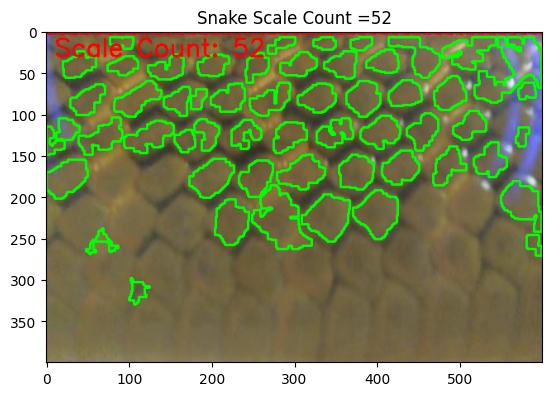

In [8]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def Canny_edge_detector(gimg,thlow = None,thhigh = None):
    gimg = cv2.GaussianBlur(gimg,(5,5),1.4)

    #2 - Compute Gradient
    gradient_x = cv2.Sobel(np.float32(gimg),cv2.CV_64F, 1, 0, 3)
    gradient_y = cv2.Sobel(np.float32(gimg),cv2.CV_64F, 0, 1, 3)

    #3- Compute Magnitude and Direction
    mag,dir = cv2.cartToPolar(gradient_x,gradient_y,angleInDegrees=True)

    # Setting minimum and maximum thresholds for Hysterisis Thresholding
    mag_max = np.max(mag)
    if not thlow: thlow = mag_max * 0.1
    if not thhigh: thhigh = mag_max  * 0.5
    print(thlow,thhigh)
    height, width = gimg.shape

    #For every pixel:
    for i_x in range(width):
        for i_y in range(height):
            grad_ang = dir[i_y, i_x]
            grad_ang = abs(grad_ang - 180) if abs(grad_ang) > 180 else abs(grad_ang)

            # X-axis
            if grad_ang <= 22.5:
                neighb_1_x, neighb_1_y = i_x - 1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y

                # top right (diagonal-1)
            elif grad_ang > 22.5 and grad_ang <= (22.5 + 45):
                neighb_1_x, neighb_1_y = i_x - 1, i_y - 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1

                # Y-axis
            elif grad_ang > (22.5 + 45) and grad_ang <= (22.5 + 90):
                neighb_1_x, neighb_1_y = i_x, i_y - 1
                neighb_2_x, neighb_2_y = i_x, i_y + 1

                # top left (diagonal-2) direction
            elif grad_ang > (22.5 + 90) and grad_ang <= (22.5 + 135):
                neighb_1_x, neighb_1_y = i_x - 1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y - 1

                # Now it restarts the cycle
            elif grad_ang > (22.5 + 135) and grad_ang <= (22.5 + 180):
                neighb_1_x, neighb_1_y = i_x - 1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y

                # Non-maximum suppression step
            if width > neighb_1_x >= 0 and height > neighb_1_y >= 0:
                if mag[i_y, i_x] < mag[neighb_1_y, neighb_1_x]:
                    mag[i_y, i_x] = 0
                    continue

            if width > neighb_2_x >= 0 and height > neighb_2_y >= 0:
                if mag[i_y, i_x] < mag[neighb_2_y, neighb_2_x]:
                    mag[i_y, i_x] = 0

    weak_ids = np.zeros_like(gimg)
    strong_ids = np.zeros_like(gimg)
    ids = np.zeros_like(gimg)

    # Hysterisis thresholding step
    for i_x in range(width):
        for i_y in range(height):

            grad_mag = mag[i_y, i_x]

            if grad_mag < thlow:
                mag[i_y, i_x] = 0
            elif thhigh > grad_mag >= thlow:
                ids[i_y, i_x] = 1
            else:
                ids[i_y, i_x] = 2

    return mag


snake = cv2.imread("snake1.jpg")
snake1 = cv2.imread("snake1.jpg",0)
cv2.imshow("snake1",snake)
#cv2.imshow("Snake Gray",snake1)
cv2.imwrite("SNAKE Snake Gray.jpg",snake1)
cv2.waitKey(0)
cv2.destroyAllWindows()

ret, threshold_image = cv2.threshold(snake1, 127, 255,cv2.THRESH_TRUNC)
#Thresholding
cv2.imshow('Truncated Thresholding', threshold_image)
cv2.imwrite('SNAKE Truncated Thresholding.jpg', threshold_image)

#Sharpening
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
sharp_img = clahe.apply(threshold_image)
cv2.imwrite("SNAKE Sharp Image.jpg",sharp_img)

cv2.waitKey(0)
cv2.destroyAllWindows()

#Cropping and Warping
selected_points = []
result = None
result_colour = None
# Function to handle mouse click events
def mouse_callback(event, x, y, flags, param):
    global result,result_colour
    if event == cv2.EVENT_LBUTTONDOWN:
        # When the user left-clicks, add the clicked point to the list
        selected_points.append((x, y))

        # Draw a colored circle to mark the selected point on the image
        color = (0, 0, 255)  
        radius = 10
        thickness = 3
        cv2.circle(sharp_img, (x, y), radius, color, thickness)

        # If two points are selected, draw a line between them
        if len(selected_points) == 2:
            cv2.line(sharp_img, selected_points[0], selected_points[1], color, thickness)
            cv2.line(snake, selected_points[0], selected_points[1], color, thickness)

        # If four points are selected, perform the perspective transform
        if len(selected_points) == 4:
            # Define the coordinates for the four corners of the rectangular output
            width, height = 600, 400  # Define the width and height of the rectangular output
            dst_points = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)

            # Convert the selected points and destination points to the format required by cv2.getPerspectiveTransform
            src_points = np.array(selected_points, dtype=np.float32)

            # Calculate the perspective transformation matrix
            perspective_matrix = cv2.getPerspectiveTransform(src_points, dst_points)

            # Perform the perspective transform
            result = cv2.warpPerspective(sharp_img, perspective_matrix, (width,height))
            result_colour = cv2.warpPerspective(snake, perspective_matrix, (width,height))

            # Display the result
            #cv2.imshow("Warped Perspective",result)
            cv2.imwrite("SNAKE Warped Perspective.jpg",result)


# Create a window to display the sharpened snake image
cv2.imshow("SELECT EDGE COORDINATES", sharp_img)
cv2.namedWindow("SELECT EDGE COORDINATES", cv2.WINDOW_NORMAL)  # Set window type
cv2.setMouseCallback("SELECT EDGE COORDINATES", mouse_callback)  # Set the mouse callback
cv2.waitKey(0)
cv2.destroyAllWindows()

#Canny Edge Detector
canny_img = Canny_edge_detector(result)
cv2.imshow("Canny",canny_img)
cv2.imwrite("SNAKE Canny.jpg",canny_img)
print(canny_img.shape)

kernel1 = np.ones((9,9), np.uint8)  
kernel2 = np.ones((9,9), np.uint8)  

#Morphological Operations
img_morph = cv2.dilate(canny_img, kernel1, iterations=1)
img_morph = cv2.erode(img_morph, kernel2, iterations=1)  
cv2.imshow("SNAKE After Morphological Operations",img_morph)
cv2.imwrite("SNAKE After Morphological Operations.jpg",img_morph)
cv2.waitKey(0)
cv2.destroyAllWindows()

print(img_morph.shape)
print(img_morph.dtype)

#Binary Thresholding
ret, modify = cv2.threshold(img_morph, 15, 255, cv2.THRESH_BINARY)
ret, modify = cv2.threshold(modify, 127, 255, cv2.THRESH_BINARY_INV)
cv2.imshow("Modified",modify)
cv2.imwrite("SNAKE After Thresholding.jpg",modify)

cv2.waitKey(0)
cv2.destroyAllWindows()
modify= cv2.convertScaleAbs(modify)

#Contour Counting
contours, _ = cv2.findContours(modify, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = list(contours)
i= 0
sum_area = 0
for contour in contours:
    area = cv2.contourArea(contour)
    sum_area += area
avg_area = sum_area/len(contours)

# Initialize a count for the number of scales
scale_count = 0
while i<len(contours):
    area = cv2.contourArea(contours[i])
    if area>avg_area*0.3 and area<avg_area*8:
        scale_count += 1
        i += 1
    else:
        contours = contours[:i] + contours[i+1:]

snake = result_colour

cv2.drawContours(snake, tuple(contours), -1, (0, 255, 0), 2)  # Draw all contours in green
cv2.waitKey(0)
cv2.destroyAllWindows()

#scale_count = len(contours)
cv2.putText(snake, f'Scale Count: {scale_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

cv2.imshow("SNAKE SCALE COUNT",snake)
cv2.imwrite("SNAKE SCALE COUNT.jpg",snake)
# Display the result
snake = cv2.cvtColor(snake,cv2.COLOR_BGR2RGB)
plt.imshow(snake)
plt.title("Snake Scale Count ="+str(scale_count))
cv2.waitKey(0)
cv2.destroyAllWindows()